# DAS Denoising -  Comparions between N2N Networks
Apply trained N2N models to Otway microseismic events.

Notebook steps: 
- [Load Packages and Scripts](#load_packages)
- [Set Display and Export Parameters](#set_param)
- [Load Data](#load_data)
- [Load Model](#load_model)
- [Preprocess Data](#data_preprocessing)
- [Apply Denoising](#apply_denoising)
- [Compute Signal to Noise Ratio](#compute_SNR)

<a id=load_packages></a>
## Load Packages and Scripts

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
import tensorflow as tf
from tensorflow.keras.models import *
# Tensorflow version
print('TensorFlow version:',tf.__version__)
# Set gpu memory if gpu is available
gpu = tf.config.list_physical_devices('GPU') # Check GPU available
print(gpu)
if gpu: 
    tf.config.experimental.set_memory_growth(gpu[0], True)

TensorFlow version: 2.10.1
[]


Import functions for data loading and signal to noise computations

In [23]:
# Import local scripts
from Utils.RP_Proc import fCalcFrameSNR, fCalcSNR2DFrame, fRingdownRemoval, fOrmsbyBPFilter
from Utils.string_manip import find_str_between
from Utils.apply_nn import fDenoiseDAS
from Utils.DAS_raw import fLoadSilixaTDMS

<a id=set_param></a>
## Set Display, Input Data Path and Name and Export Parameters

In [4]:
# Input data
data_path = r'Data\Otway'
tdms_files = [os.path.join(data_path,x) for x in os.listdir(data_path) if '.tdms' in x]
tdms_files;

In [5]:
# Plot parameters
plt.rc('axes',labelsize=14)
plt.rc('font',size=14)
plt.rc('xtick',labelsize='medium')
plt.rc('ytick',labelsize='medium')
plt.rc('grid', linestyle=':', linewidth=0.5)
interpolation_opt = 'sinc'
c_map = 'seismic'
v_max = 15

In [7]:
# Optional pre-processing steps
apply_detrend = True
apply_ringDownRemoval = True

In [8]:
# Input models
model_NGL_N2N = 'Models\\N2N_LowPowerSourceTest_30ep_v10_patch128x96_dgtarget_fliplr.h5'
model_Lapins = 'Models\\dasn2n_model_Lapins'

<a id=load_data></a>
## Load Data

In [9]:
# Load data
D, dx, mlength, dt = fLoadSilixaTDMS(tdms_files[0])
# Check size
np.shape(D)

(30000, 3456)

In [10]:
dt

0.001

Channel selection:

In [11]:
ch_range = [105,1680]; #CRC7
ch_start = ch_range[0]
ch_end = ch_range[1] 
# Define time range from event
ti_start = 2000
ti_end = 10000
D = D[ti_start:ti_end,ch_start:ch_end];
if apply_detrend:
    D = signal.detrend(D,axis=0)
if apply_ringDownRemoval:
    D = fRingdownRemoval(D)
D.shape

(8000, 1575)

<a id=load_model></a>
## Load Models

In [22]:
# N2N Current Study
dasn2n = load_model(model_NGL_N2N) # DAS-N2N
# N2N Lapins
n_epochs = 30 #set decay rate to number of epochs
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-3,
    decay_steps=n_epochs,
    end_learning_rate=1e-5,
    power=1.0,
    cycle=False,
    name=None,)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
dasn2n_Lapins = load_model(model_Lapins, compile=False)
dasn2n.compile(optimizer=optimizer, loss="mean_squared_error")

<a id=apply_denoising></a>
## Apply Denoising

In [16]:
%%time
st_array_out = fDenoiseDAS(D, dasn2n, 
                           apply_detrend=apply_detrend, apply_ringDownRemoval=apply_ringDownRemoval)

Extracting 4125 patches
wHann_submatrices[128, 96]
(1, 8064, 1632)
CPU times: total: 3min 56s
Wall time: 25.5 s


In [17]:
st_array_out_Lapins = fDenoiseDAS(D, dasn2n_Lapins, 
                           apply_detrend=apply_detrend, apply_ringDownRemoval=apply_ringDownRemoval)

Extracting 4125 patches
wHann_submatrices[128, 96]
(1, 8064, 1632)


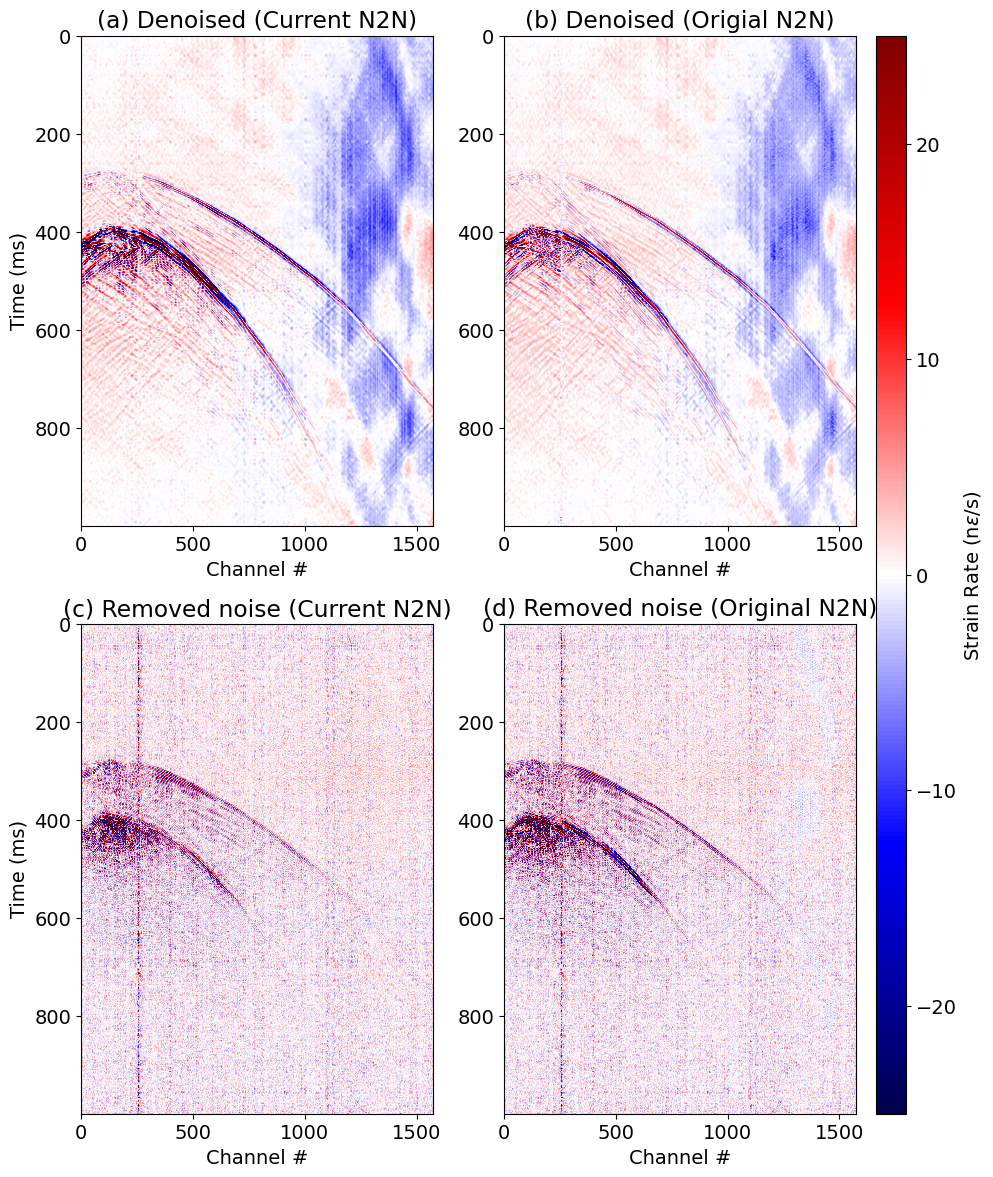

In [19]:
fig, axs = plt.subplots(2,2,figsize=(10,14))
ch_start_display=0
ch_end_display=1575
t_start_display=1800
t_end_display=2800
v_max = 25
#--1st row: gathers
axs[0,0].imshow(st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                vmin=-v_max, vmax=v_max)
axs[0,0].set(title='(a) Denoised (Current N2N)', xlabel='Channel #', ylabel='Time (ms)')
axs[0,1].imshow(st_array_out_Lapins[t_start_display:t_end_display,ch_start_display:ch_end_display], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                vmin=-v_max, vmax=v_max)
axs[0,1].set(title='(b) Denoised (Origial N2N)', xlabel='Channel #')
axs[1,0].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                vmin=-v_max, vmax=v_max)
axs[1,0].set(title='(c) Removed noise (Current N2N)', xlabel='Channel #', ylabel='Time (ms)')
im = axs[1,1].imshow(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out_Lapins[t_start_display:t_end_display,ch_start_display:ch_end_display], 
                    interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                    vmin=-v_max, vmax=v_max)
axs[1,1].set(title='(d) Removed noise (Original N2N)', xlabel='Channel #')
# Add single colorbar to the right
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.11, 0.03, 0.77])
fig.colorbar(im, cax=cbar_ax, label='Strain Rate (n$\epsilon$/s)')
plt.show()    

<a id=compute_SNR></a>
## Compute Signal to Noise Ratio

SNR frame values

In [20]:
maxlag = 0.1 #(in s)
percent = 30;
ch_start_display = 0
snr_frame_in = fCalcFrameSNR(D[t_start_display:t_end_display,ch_start_display:ch_end_display],
                             percent,np.ceil(maxlag/dt).astype(int))
#--Current N2N results
snr_frame_out = fCalcFrameSNR(st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display],
                              percent,np.ceil(maxlag/dt).astype(int))
snr_frame_noise = fCalcFrameSNR(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out[t_start_display:t_end_display,ch_start_display:ch_end_display],
                                percent,np.ceil(maxlag/dt).astype(int))
#--Lapins results
snr_frame_out_Lapins = fCalcFrameSNR(st_array_out_Lapins[t_start_display:t_end_display,ch_start_display:ch_end_display],
                              percent,np.ceil(maxlag/dt).astype(int))
snr_frame_noise_Lapins = fCalcFrameSNR(D[t_start_display:t_end_display,ch_start_display:ch_end_display]-st_array_out_Lapins[t_start_display:t_end_display,ch_start_display:ch_end_display],
                                percent,np.ceil(maxlag/dt).astype(int))

In [21]:
print(snr_frame_in, snr_frame_out, snr_frame_noise, snr_frame_out_Lapins, snr_frame_noise_Lapins)

2.651688136880204 7.735312509930919 2.1293042528157984 6.6491918797188045 2.227990214624145
